In [1]:
from model import MultitaskBERTModel, train_model, test_model
from data_visualization import show_training_history
from utils import load_data, impute_metadata

import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Integer
from transformers import logging

PATH_TRAIN = '../Data/Training/train.csv'
PATH_TEST = '../Data/Training/test.csv'
PATH_DEV = '../Data/Training/dev.csv'

PATH_META = '../Data/Processed/metadata.csv'
PATH_MODEL = '../Models/model_weights.pth'
PATH_PREDICTIONS = '../Data/predictions.csv'

logging.set_verbosity_error()

/home/kiryn/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df_dev = pd.read_csv(PATH_DEV)
df_meta = pd.read_csv(PATH_META)
df = pd.merge(df_dev, df_meta, on=['index'], how='left').sample(1000)

train, val = train_test_split(df, test_size=0.2, random_state=42)

train = load_data(train)
val = load_data(val)

def objective_function(params):
    num_preds, hidden_dim = params

    model = MultitaskBERTModel(
        num_preds=num_preds,
        hidden_dim=hidden_dim
    )

    train_loss_history, val_loss_history = train_model(
        model, train, val,
        num_preds=num_preds,
        epochs=5,
        batch_size=8,
        learning_rate=1e-4,
    )

    return val_loss_history[-1]

search_space = [
    Integer(3, 10, name="num_preds"),
    Integer(128, 512, name="hidden_dim")
]

result = gp_minimize(
    func=objective_function,
    dimensions=search_space,
    n_calls=10,
    random_state=42
)

print("Best hyperparameters:")
print(f"Num Preds: {result.x[0]}")
print(f"Hidden Dim: {result.x[1]}")
print(f"Best Validation Loss: {result.fun}")

Best hyperparameters:
Num Preds: 3
Hidden Dim: 330
Best Validation Loss: 4.468039836883545


Epoch 1/3


Training: 100%|██████████| 20157/20157 [2:06:43<00:00,  2.65it/s]  


Training Loss: 7.2995



Validating: 100%|██████████| 1120/1120 [02:10<00:00,  8.58it/s]


Validation  Loss: 6.6855
------------------------------
Epoch 2/3


Training: 100%|██████████| 20157/20157 [2:06:30<00:00,  2.66it/s]  


Training Loss: 6.4925



Validating: 100%|██████████| 1120/1120 [02:10<00:00,  8.61it/s]


Validation  Loss: 6.3906
------------------------------
Epoch 3/3


Training: 100%|██████████| 20157/20157 [2:05:58<00:00,  2.67it/s]  


Training Loss: 6.3066



Validating: 100%|██████████| 1120/1120 [02:09<00:00,  8.67it/s]


Validation  Loss: 6.1730
------------------------------


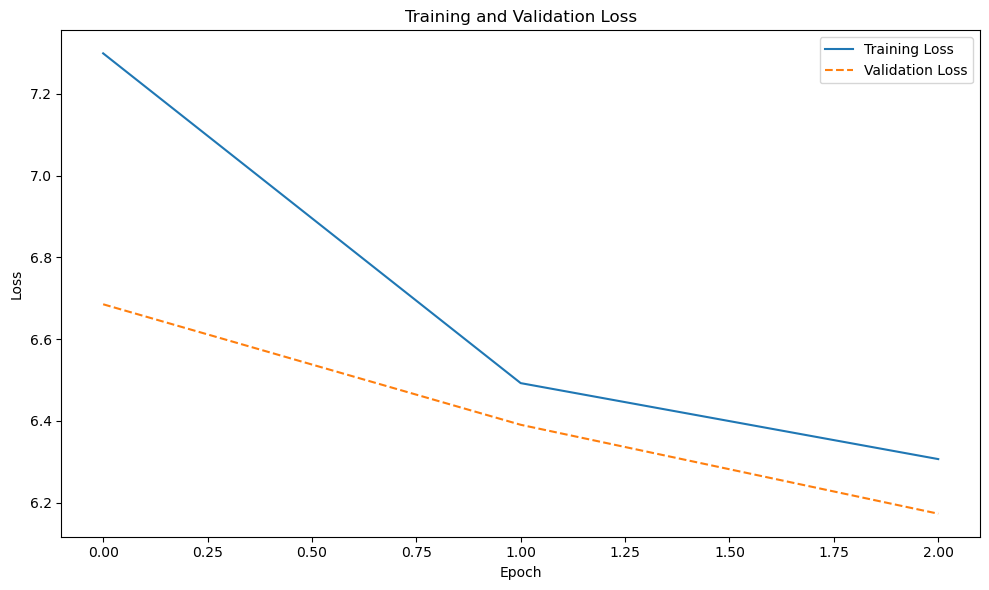

In [3]:
NUM_PREDS = 3
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 1e-4
HIDDEN_DIM = 330

df_train = pd.read_csv(PATH_TRAIN)
df_dev = pd.read_csv(PATH_DEV)
df_meta = pd.read_csv(PATH_META)

train = pd.merge(df_train, df_meta, on=['index'], how='left')
val = pd.merge(df_dev, df_meta, on=['index'], how='left')

train = impute_metadata(load_data(train))
val = impute_metadata(load_data(val))

model = MultitaskBERTModel(num_preds=NUM_PREDS, hidden_dim=HIDDEN_DIM)
train_loss_history, val_loss_history = train_model(
    model, train, val, 
    num_preds=NUM_PREDS, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    learning_rate=LEARNING_RATE
)

show_training_history(train_loss_history, val_loss_history)
torch.save(model.state_dict(), PATH_MODEL)

In [12]:
NUM_PREDS = 3
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 1e-4
HIDDEN_DIM = 330

df_test = pd.read_csv(PATH_TEST)
df_meta = pd.read_csv(PATH_META)

df = pd.merge(df_test, df_meta, on=['index'], how='left')
test = impute_metadata(load_data(df), nan_percentage=0)

model = MultitaskBERTModel(num_preds=NUM_PREDS, hidden_dim=HIDDEN_DIM)
model.load_state_dict(torch.load(PATH_MODEL))
results = test_model(model, test, NUM_PREDS, BATCH_SIZE)

df.reset_index(drop=True, inplace=True)
df['index'] = df.index
df = df[['index', 'text']]

results['index'] = results.index
results_text = pd.merge(results, df, on=['index'], how='left')
results_text.to_csv(PATH_PREDICTIONS, index=False)

/tmp/ipykernel_1061/2155008252.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH_MODEL))
Testing: 100%|██████████| 1120/1120 [02:06<

-------------------------------------
Results:
Mean SAE: 276.95
Median SAE: 124.29
Acc@161: 57.69
Precision: 0.04
Recall: 0.04
F1 Score: 0.04
